# Classification by Wine Type

## Wine Data
Data from http://archive.ics.uci.edu/ml/datasets/Wine+Quality

### Citations
<pre>
Dua, D. and Karra Taniskidou, E. (2017). 
UCI Machine Learning Repository [http://archive.ics.uci.edu/ml/index.php]. 
Irvine, CA: University of California, School of Information and Computer Science.
</pre>

<pre>
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
Modeling wine preferences by data mining from physicochemical properties.
In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.
</pre>

Available at:
- [@Elsevier](http://dx.doi.org/10.1016/j.dss.2009.05.016)
- [Pre-press (pdf)](http://www3.dsi.uminho.pt/pcortez/winequality09.pdf)
- [bib](http://www3.dsi.uminho.pt/pcortez/dss09.bib)
## Setup

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

Read in the data:

In [27]:
from distutils.log import info


red_wine = pd.read_csv('data/winequality-red.csv')
white_wine = pd.read_csv('data/winequality-white.csv', sep=';')

# red_wine.sample(10) #, random_state=1)
# white_wine.sample(10) #, random_state=1)
# red_wine.info()
# white_wine.info()

## EDA

In [28]:
white_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [38]:
red_wine.head()
# red_wine.shape

(1599, 12)

### Looking at quality scores

<AxesSubplot:title={'center':'White Wine Quality Scores'}, xlabel='count of wines', ylabel='quality score'>

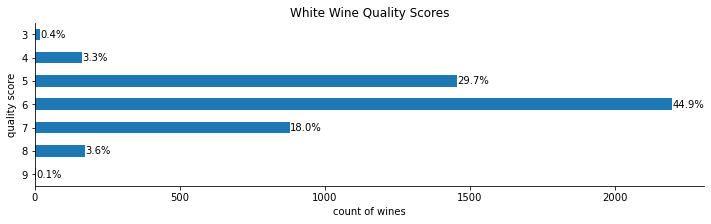

In [35]:
def plot_quality_scores(df, kind):
    # ax = df.quality.value_counts().sort_index().plot.barh(
    ax = df['quality'].value_counts().sort_index().plot.barh(
        title=f'{kind.title()} Wine Quality Scores', figsize=(12, 3)
    )
    ax.axes.invert_yaxis()
    for bar in ax.patches:
        ax.text(
            bar.get_width(), 
            bar.get_y() + bar.get_height()/2, 
            f'{bar.get_width()/df.shape[0]:.1%}',
            verticalalignment='center'
        )
    plt.xlabel('count of wines')
    plt.ylabel('quality score')

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    return ax

plot_quality_scores(white_wine, 'white')

<AxesSubplot:title={'center':'Red Wine Quality Scores'}, xlabel='count of wines', ylabel='quality score'>

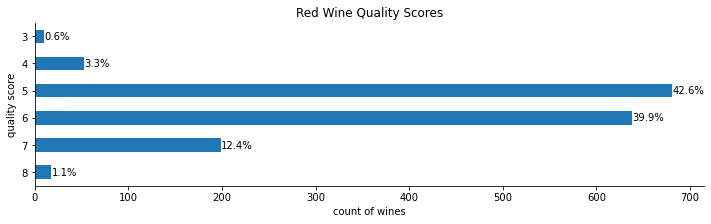

In [36]:
plot_quality_scores(red_wine, 'red')

### Combining red and white wine data

In [39]:
wine = pd.concat([
    white_wine.assign(kind='white'), red_wine.assign(kind='red')
])
wine.sample(5, random_state=10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,kind
848,6.4,0.64,0.21,1.8,0.081,14.0,31.0,0.99689,3.59,0.66,9.8,5,red
2529,6.6,0.42,0.13,12.8,0.044,26.0,158.0,0.99772,3.24,0.47,9.0,5,white
131,5.6,0.50,0.09,2.3,0.049,17.0,99.0,0.99370,3.63,0.63,13.0,5,red
244,15.0,0.21,0.44,2.2,0.075,10.0,24.0,1.00005,3.07,0.84,9.2,7,red
1551,6.6,0.19,0.99,1.2,0.122,45.0,129.0,0.99360,3.09,0.31,8.7,6,white


No null data:

In [40]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6497 entries, 0 to 1598
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  kind                  6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 710.6+ KB


We have more whites than reds:

In [41]:
wine['kind'].value_counts()

white    4898
red      1599
Name: kind, dtype: int64

We want to understand if chemical properties can be used to determine wine type. Unfortunately, `describe()` gives a very long output, so we need a visualization to compare the wines this way:

In [42]:
wine.drop(columns='quality').groupby('kind').describe()

fixed acidity                                                \
              count      mean       std  min  25%  50%  75%   max   
kind                                                                
red          1599.0  8.319637  1.741096  4.6  7.1  7.9  9.2  15.9   
white        4898.0  6.854788  0.843868  3.8  6.3  6.8  7.3  14.2   

      volatile acidity            ... sulphates       alcohol             \
                 count      mean  ...       75%   max   count       mean   
kind                              ...                                      
red             1599.0  0.527821  ...      0.73  2.00  1599.0  10.422983   
white           4898.0  0.278241  ...      0.55  1.08  4898.0  10.514267   

                                             
            std  min  25%   50%   75%   max  
kind                                         
red    1.065668  8.4  9.5  10.2  11.1  14.9  
white  1.230621  8.0  9.5  10.4  11.4  14.2  

[2 rows x 88 columns]

### How do chemical properties of the wine correlate to each other and the wine type?
It's important to perform an in-depth exploration of the data before modeling. This includes consulting domain experts, looking for correlations between variables, examining distributions, etc. The visualizations covered in chapters 5 and 6 will prove indispensible for this process. One such visualization is the heatmap. In order to predict if the wine is red or white, we would look for correlations between chemical properties and wine type. We would also try to see if there is a difference in the distribution of our variables for white versus red wines. Some other helpful plot types include box plots, pair plots, and the scatter matrix. 

In [ ]:
fig = plt.figure(figsize=(7, 7))
sns.heatmap(
    wine.drop(columns='quality').assign(
        is_red=lambda x: np.where(x.kind == 'red', 1, 0)
    ).corr(), 
    cbar_kws={'shrink': 0.8},
    center=0, vmin=-1, vmax=1,
    square=True, annot=True, fmt='.1g'
)

### Comparison of Red and White Wines by Their Chemical Properties
This visualization will be easier to digest than the output of `describe()`:

In [ ]:
import math

chemical_properties = [col for col in wine.columns if col not in ['quality', 'kind']]
melted = wine.drop(columns='quality').melt(id_vars=['kind'])

fig, axes = plt.subplots(math.ceil(len(chemical_properties) / 4), 4, figsize=(15, 10))
axes = axes.flatten()

for prop, ax in zip(chemical_properties, axes):
    sns.boxplot(
        data=melted[melted.variable.isin([prop])], 
        x='variable', y='value', hue='kind', ax=ax
    ).set_xlabel('')
    
# remove the extra subplots
for ax in axes[len(chemical_properties):]:
    ax.remove()

plt.suptitle('Comparing Chemical Properties of Red and White Wines')
plt.tight_layout()

## Classification of Red and White Wines
1. separate x and y
2. get the training and testing set

In [ ]:
from sklearn.model_selection import train_test_split

# 1
wine_y = np.where(wine.kind == 'red', 1, 0)
wine_X = wine.drop(columns=['quality', 'kind'])

# 2
w_X_train, w_X_test, w_y_train, w_y_test = train_test_split(
    wine_X, wine_y, test_size=0.25, random_state=0, stratify=wine_y
)

3. build a pipeline with standard scaler followed by logistic regression and fit the model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

white_or_red = Pipeline([
    ('scale', StandardScaler()), 
    ('lr', LogisticRegression(random_state=0))
]).fit(w_X_train, w_y_train)

4. make predictions

In [ ]:
kind_preds = white_or_red.predict(w_X_test)

5. evaluate predictions

We can use a confusion matrix to see how the model's predictions align with the actual class labels. The model only made 13 incorrect predictions; we will look into these in chapter 10:

In [ ]:
from ml_utils.classification import confusion_matrix_visual

confusion_matrix_visual(w_y_test, kind_preds, ['white', 'red'])

Precision, recall, and $F_1$ score all look good with this model:

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(w_y_test, kind_preds))

Another way to use the confusion matrix is with sensitivity and specificity:

In [ ]:
from visual_aids import ml_viz
ml_viz.portion_of_confusion_matrix_considered({'sensitivity', 'specificity'})

Sensitivity-specificity plots plot sensitivity (TPR) versus 1-specificity (FPR) and are another way to evaluate performance. They include all sections of the confusion matrix, which is why in cases of class balance, they are optimistic of performance. These plots are also called ROC curves.

### ROC Curves
Visualize model performance using true positive rates and false positive rates. The area under the curve is in the range [0, 1] with 1 being the best. This visualization allows us to compare our model to the baseline of random guessing (the diagonal line with AUC of 0.5), as well as, other models:

In [ ]:
ml_viz.roc_curve()

This model performs very well, the area under the curve (AUC) is nearly 1:

In [ ]:
from ml_utils.classification import plot_roc

plot_roc(w_y_test, white_or_red.predict_proba(w_X_test)[:,1])

### Precision-recall curves
When faced with class imbalance, we use precision-recall curves since ROC curves will be optimistic of model performance. AP is the weighted average precision and AUC is the area under the curve once again in the range [0, 1]. The baseline is now the percentage of observations belonging to the positive class. Values below this line are worse than random:

In [ ]:
from ml_utils.classification import plot_pr_curve

plot_pr_curve(w_y_test, white_or_red.predict_proba(w_X_test)[:,1])

<hr>
<div style="overflow: hidden; margin-bottom: 10px;">
    <div style="float: left;">
        <a href="../../ch_08/anomaly_detection.ipynb">
            <button>&#8592; Chapter 8</button>
        </a>
        <a href="./preprocessing.ipynb">
            <button>Preprocessing</button>
        </a>
        <a href="./planets_ml.ipynb">
            <button>Planets</button>
        </a>
        <a href="./red_wine.ipynb">
            <button>Red Wine</button>
        </a>
    </div>
    <div style="float: right;">
        <a href="../../solutions/ch_09/exercise_1.ipynb">
            <button>Solutions</button>
        </a>
        <a href="../ch_10/red_wine.ipynb">
            <button>Chapter 10 &#8594;</button>
        </a>
    </div>
</div>
<hr>